### Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import cpu_count
import networkx as ntx
import csv
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from sklearn.externals import joblib
from collections import defaultdict, Counter
from multiprocessing import Pool
from scipy.sparse.linalg import svds

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

#  Loading the dataset

In [3]:
!ls dataset/

cleaned_df.csv	    pairs.p		  Xtest.csv	       ytrain.npy
data_no_header.csv  pr.p		  Xtrain.csv
hits.p		    sample_no_header.csv  Xtrain_featured.csv
katz.p		    train.csv		  ytest.npy


In [4]:
!cat ./dataset/train.csv | wc -l

9437520


In [5]:
cpu_count()

16

In [6]:
!head -n 5 ./dataset/train.csv

In [7]:
data = pd.read_csv('./dataset/train.csv')

In [8]:
data.shape

(9437519, 2)

In [9]:
data.columns

Index(['source_node', 'destination_node'], dtype='object')

In [10]:
print('Number of Followers:', data.source_node.unique().shape[0])

Number of Followers: 1587708


In [11]:
print('Number of Followees:', data.destination_node.unique().shape[0])

Number of Followees: 1674177


In [12]:
data.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [13]:
data.to_csv('./dataset/data_no_header.csv', header=False, index=False)

In [14]:
!head -n 5 ./dataset/data_no_header.csv

1,690569
1,315892
1,189226
2,834328
2,1615927


# 1. Exploration

In [8]:
%%time
g = ntx.read_edgelist('./dataset/data_no_header.csv',
                     delimiter=',',
                     create_using=ntx.DiGraph(),
                     nodetype=int)

CPU times: user 1min 9s, sys: 2.58 s, total: 1min 11s
Wall time: 1min 11s


In [16]:
%%time
print(ntx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679
CPU times: user 3.43 s, sys: 0 ns, total: 3.43 s
Wall time: 3.43 s


In [17]:
data.head(50).to_csv(
    './dataset/sample_no_header.csv',
    header=False, index=False)

In [18]:
subgraph = ntx.read_edgelist(
    './dataset/sample_no_header.csv',
    delimiter=',',
    create_using=ntx.DiGraph(),
    nodetype=int)

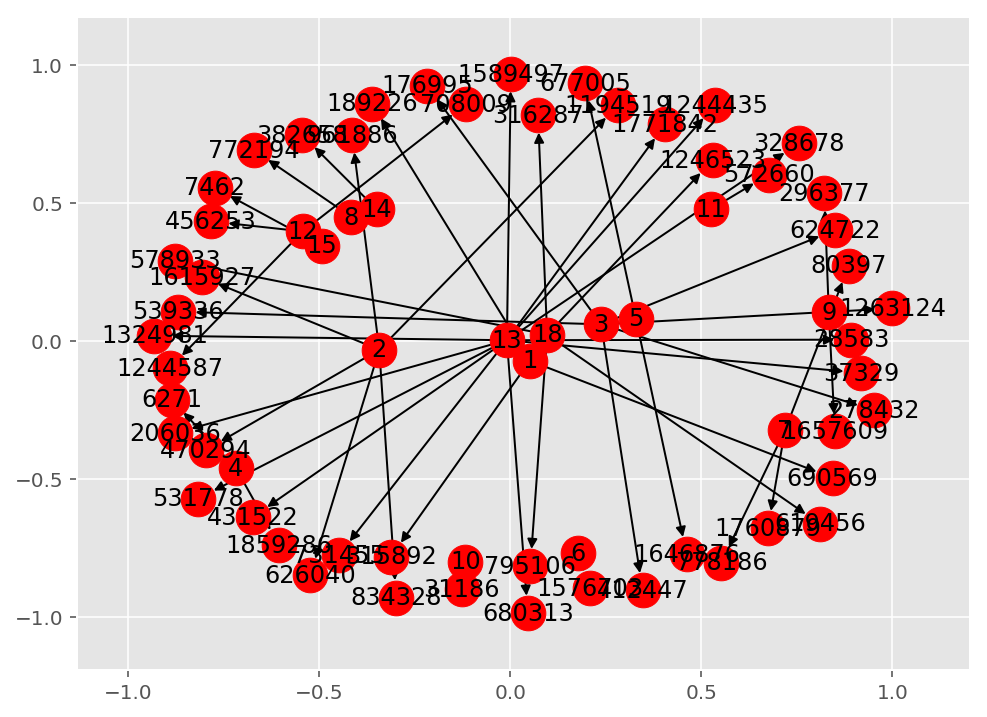

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
ntx.draw_networkx(subgraph, ax=ax)

In [20]:
print('Number of unique nodes:', len(g.nodes()))

Number of unique nodes: 1862220


### Generating some edges which are not present in graph for supervised learning

In [23]:
# ckpts = np.arange(1, 9437519, 1000)

In [ ]:
%%time
with open('./dataset/data_no_header.csv', 'r') as fin:
    edge_file = csv.reader(fin)
    edges = dict()
    for each_edge in edge_file:
        edges[(each_edge[0], each_edge[1])] = 1
    missing_edges = set([])
    while len(missing_edges) < 9437519:
#         if len(missing_edges) in ckpts:
#             print(len(missing_edges))
        a, b = np.random.randint(low=1, high=1862221, size=(2,))
        if a == b:
            # One in a million chance to get a and b same
            continue
        # Check if the there is already a edge between these nodes
        isLinked = edges.get((a, b), 0)
        if not isLinked:
            try:
                spl = ntx.shortest_path_length(g, source=a, target=b)
                if spl > 2:
                    # If there is edge but it length is more than 2
                    missing_edges.add((a, b))
                else:
                    continue
            except ntx.NetworkXNoPath:
                # If there is no edge between nodes
                missing_edges.add((a, b))
        else:
            continue

```
CPU times: user 2h 29min 6s, sys: 2min 59s, total: 2h 32min 6s
Wall time: 2h 44min 34s
```

In [25]:
len(missing_edges)

9437519

In [26]:
len(edges)

9437519

In [27]:
assert(len(missing_edges) == len(edges))

In [30]:
for each in tqdm(missing_edges):
    edges[(each[0], each[1])] = 0

100%|██████████| 9437519/9437519 [00:14<00:00, 671052.42it/s] 


In [36]:
assert(len(edges) == len(missing_edges) * 2)

In [39]:
data = defaultdict(list)

In [40]:
for node, isedge in edges.items():
    data['node1'].append(node[0])
    data['node2'].append(node[1])
    data['edge'].append(isedge)

In [42]:
df = pd.DataFrame.from_dict(data)

In [43]:
df.head()

,node1,node2,edge
0,1,690569,1
1,1,315892,1
2,1,189226,1
3,2,834328,1
4,2,1615927,1


In [44]:
df.shape

(18875038, 3)

In [45]:
df.edge.unique()

array([1, 0])

### Checkpoint

In [47]:
df.to_csv('./dataset/cleaned_df.csv', index=False)

### Load the dataset

In [22]:
df = pd.read_csv('./dataset/cleaned_df.csv')

In [23]:
df.head()

,node1,node2,edge
0,1,690569,1
1,1,315892,1
2,1,189226,1
3,2,834328,1
4,2,1615927,1


In [24]:
df.shape

(18875038, 3)

### Splitting the dataset

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[['node1', 'node2']], df.edge, 
                                                    random_state=42, test_size=0.2)

In [27]:
X_train.shape

(15100030, 2)

In [28]:
X_test.shape

(3775008, 2)

In [30]:
Counter(y_train)

Counter({1: 7549166, 0: 7550864})

In [31]:
Counter(y_test)

Counter({1: 1888353, 0: 1886655})

### Checkpoint 2

In [44]:
X_train.to_csv('./dataset/Xtrain.csv', index=False, header=False)
X_test.to_csv('./dataset/Xtest.csv', index=False, header=False)
np.save('./dataset/ytrain', y_train)
np.save('./dataset/ytest', y_test)

In [10]:
del g

### Build the train_graph

In [6]:
%%time
train_g = ntx.read_edgelist('./dataset/Xtrain.csv',
                     delimiter=',',
                     create_using=ntx.DiGraph(),
                     nodetype=int)

CPU times: user 1min 46s, sys: 3.7 s, total: 1min 50s
Wall time: 1min 50s


# 2. Feature Engineering

## 2.1 Neighbor-based Metrics

### Common Neighbors

$$
CN(x, y) = |\tau(x) \cap \tau(y)|
$$

In [57]:
def common_neighbors(x, y):
#     if of == 'predecessor':
    try:
        return len(set(train_g.neighbors(x)).intersection(
        set(train_g.neighbors(y))))
    except:
        return 0
#     return len(set(train_g.successors(x)).intersection(
#         set(train_g.successors(y))))

In [58]:
print(common_neighbors(1, 189226))
print(common_neighbors(273084, 1505602))

1
0


### Jaccard Coefficient

$$
JC(x, y) = \frac{|\tau(x) \cap \tau(y)|}{|\tau(x) \cup \tau(y)|}
$$

In [59]:
def jaccard_coefficient(x, y):
    try:
        intersect = common_neighbors(x, y)
    #     if of == 'predecessor':
        return intersect / len(set(train_g.neighbors(x)).union(
            set(train_g.neighbors(y))))
    except:
        return 0
#     return intersect / len(set(train_g.successors(x)).union(
#         set(train_g.successors(y))))

In [60]:
print(jaccard_coefficient(1, 189226))
print(jaccard_coefficient(273084, 1505602))

0.125
0.0


### Sørensen  Index

$$
SI(x, y) = \frac{|\tau(x) \cap \tau(y)|}{|\tau(x)| + |\tau(y)|}
$$

In [63]:
def sorensen_index(x, y):
    try:
        intersect = common_neighbors(x, y)
    #     if of == 'predecessor':
        return intersect / (len(set(train_g.neighbors(x))) + \
        len(set(train_g.neighbors(y))))
    except:
        return 0.0
#     return intersect / (len(set(train_g.successors(x))) + \
#     len(set(train_g.successors(y))))

In [64]:
print(sorensen_index(1, 189226))
print(sorensen_index(273084, 1505602))

0.1111111111111111
0.0


### Salton Cosine Similarity

$$
SC(x, y) = \frac{|\tau(x) \cap \tau(y)|}{\sqrt{|\tau(x)| * |\tau(y)|}}
$$

In [65]:
def salton_cosine(x, y):
    try:
        intersect = common_neighbors(x, y)
    #     if of == 'predecessor':
        nx = len(set(train_g.neighbors(x)))
        ny = len(set(train_g.neighbors(y)))
        return intersect / np.sqrt(nx * ny)
    except:
        return 0.0
#     nx = len(set(train_g.successors(x)))
#     ny = len(set(train_g.successors(y)))
#     return intersect / np.sqrt(nx * ny)

In [66]:
print(salton_cosine(1, 189226,))
print(salton_cosine(273084, 1505602,))

0.22360679774997896
0.0


### Hub Promoted

$$
HP(x, y) = \frac{|\tau(x) \cap \tau(y)|}{\min(|\tau(x)|, |\tau(y)|)}
$$

In [67]:
def hub_promoted(x, y):
    try:
        intersect = common_neighbors(x, y)
        nx = len(set(train_g.neighbors(x)))
        ny = len(set(train_g.neighbors(y)))
        return intersect / (min(nx, ny) + 0.001)
    except:
        return 0.0

In [68]:
print(hub_promoted(1, 189226,))
print(hub_promoted(273084, 1505602,))

0.2499375156210947
0.0


### Hub Depressed

$$
HD(x, y) = \frac{|\tau(x) \cap \tau(y)|}{\max(|\tau(x)|, |\tau(y)|)}
$$

In [69]:
def hub_depressed(x, y):
    try:
        intersect = common_neighbors(x, y)
        nx = len(set(train_g.neighbors(x)))
        ny = len(set(train_g.neighbors(y)))
        return intersect / (max(nx, ny) + 0.001)
    except:
        return 0

In [70]:
print(hub_promoted(1, 189226,))
print(hub_promoted(273084, 1505602,))

0.2499375156210947
0.0


### Leicht-Holme-Nerman

$$
LHN(x, y) = \frac{|\tau(x) \cap \tau(y)|}{|\tau(x)| * |\tau(y)|)}
$$

In [71]:
def leicht_holme_nerman(x, y):
    try:
        intersect = common_neighbors(x, y)
        nx = len(set(train_g.neighbors(x)))
        ny = len(set(train_g.neighbors(y)))
        return intersect / ((nx * ny) + 0.001)
    except:
        return 0

In [72]:
print(leicht_holme_nerman(1, 189226,))
print(leicht_holme_nerman(273084, 1505602,))

0.049997500124993745
0.0


### Adamic-Adar Coefficient

$$
AA(x, y) = \sum_{z \in N(x) \cap N(y)}\frac{1}{log(|\tau(z)|)}
$$

In [73]:
def adamic_index(x, y):
    try:
        nodes = set(train_g.successors(x)).intersection(
            train_g.successors(y))
        total = 0
        for n in nodes:
            total += 1 / np.log10(len(set(train_g.predecessors(n))))
        return total
    except:
        return 0

In [74]:
print(adamic_index(1, 189226,))
print(adamic_index(273084, 1505602,))

0.6986344247631282
0


### Preferential  Attachment

$$
PA(x, y) = |\tau(x)| * |\tau(y)|
$$

In [75]:
def preferential_attachment(x, y):
    try:
        return len(set(train_g.successors(x))) * len(
            set(train_g.successors(y)))
    except:
        return 0

In [76]:
print(preferential_attachment(1, 189226,))
print(preferential_attachment(273084, 1505602,))

20
180


### Resource Allocation

$$
RA(x, y) = \sum_{z \in N(x) \cap N(y)}\frac{1}{|N(z)|}
$$

In [77]:
def resource_allocation(x, y):
    try:
        nodes = set(train_g.successors(x)).intersection(
            train_g.successors(y))
        total = 0
        for n in nodes:
            total += 1 / len(set(train_g.predecessors(n)))
        return total
    except:
        return 0

In [78]:
print(resource_allocation(1, 189226,))
print(resource_allocation(273084, 1505602,))

0.037037037037037035
0


## 2.2 Path-based Metrics

### Katz

In [ ]:
katz = ntx.katz.katz_centrality(train_g, alpha=0.005, beta=1)

In [31]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007010514682016344
max 0.003299981294781887
mean 0.0007318229029406612


In [32]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007318229029406612


In [34]:
joblib.dump(katz, './dataset/katz.p')

['./dataset/katz.p']

## 2.3 Random Walk based Metrics

### Hits Score

In [ ]:
hits = ntx.hits(train_g, max_iter=100, 
               tol=1e-08, nstart=None, 
               normalized=True)

In [ ]:
joblib.dump(hits, './dataset/hits.p')

In [38]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


### PageRank

In [5]:
pr = ntx.pagerank(train_g, alpha=0.85)

In [6]:
joblib.dump(pr, './dataset/pr.p')

['./dataset/pr.p']

In [7]:
pr = joblib.load('./dataset/pr.p')

### Shortest path between nodes

In [79]:
# Code Courtesy : AAIC

def shortest_path_length(a, b):
    p = -1
    try:
        if train_g.has_edge(a, b):
            train_g.remove_edge(a, b)
            p = ntx.shortest_path_length(train_g, source=a, target=b)
            train_g.add_edge(a, b)
        else:
            p = ntx.shortest_path_length(train_g, source=a, target=b)
        return p
    except:
        return -1

In [80]:
shortest_path_length(77697, 826021)

7

In [81]:
shortest_path_length(669354,1635354)

9

## 2.4 Other Features

### Ranking Measures

### Weakly Connected Components

In [115]:
wcc = list(ntx.weakly_connected_components(train_g))

In [116]:
#getting weekly connected edges from graph 
def belongs_to_same_wcc(a, b):
    index = []
    if train_g.has_edge(b, a):
        return 1
    if train_g.has_edge(a, b):
        for i in wcc:
            if a in i:
                index= i
                break
        if (b in index):
            train_g.remove_edge(a, b)
            if shortest_path_length(a,b)==-1:
                train_g.add_edge(a,b)
                return 0
            else:
                train_g.add_edge(a,b)
                return 1
        else:
            return 0
    else:
        for i in wcc:
            if a in i:
                index= i
                break
        if(b in index):
            return 1
        else:
            return 0

In [117]:
belongs_to_same_wcc(861, 1659750)

1

In [118]:
belongs_to_same_wcc(669354,1635354)

1

### Follows Back

In [108]:
def follows_back(a, b):
    if train_g.has_edge(b,a):
        return 1
    else:
        return 0

In [109]:
follows_back(1, 189226)

1

In [110]:
follows_back(669354, 1635354)

0

### Weight Features

In [49]:
## Code Courtesy: AAIC

Weight_in = {}
Weight_out = {}
for i in train_g.nodes():
    s1 = set(train_g.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i] = w_in
    
    s2 = set(train_g.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i] = w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1862201/1862201 [00:22<00:00, 81255.27it/s] 


### svd_dot

In [11]:
sadj_col = sorted(train_g.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [12]:
Adj = ntx.adjacency_matrix(train_g, nodelist=sorted(train_g.nodes())).asfptype()

In [13]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return np.zeros(6,)

In [14]:
U, s, V = svds(Adj, k = 6)

In [146]:
print('Adjacency matrix Shape', Adj.shape)
print('U Shape', U.shape)
print('V Shape', V.shape)
print('s Shape', s.shape)

Adjacency matrix Shape (1862201, 1862201)
U Shape (1862201, 6)
V Shape (6, 1862201)
s Shape (6,)


In [16]:
source_svd = X_train.source.progress_apply(lambda x: svd(x, U))

100%|██████████| 15100030/15100030 [00:39<00:00, 384644.60it/s]


In [28]:
S = []
for each in source_svd:
    k = each.reshape(1, 6)[0]
    S.append(k)

In [30]:
S = np.array(S)

In [33]:
dest_svd = X_train.destination.progress_apply(lambda x: svd(x, U))

100%|██████████| 15100030/15100030 [00:35<00:00, 422582.15it/s]


In [34]:
D = []
for each in dest_svd:
    k = each.reshape(1, 6)[0]
    D.append(k)
    
D = np.array(D)

In [35]:
D.shape

(15100030, 6)

In [45]:
DOT = np.einsum('ij,ij->i', S, D)

In [48]:
DOT.shape

(15100030,)

In [147]:
source_svd = X_test.source.apply(lambda x: svd(x, U))
S2 = []
for each in source_svd:
    k = each.reshape(1, 6)[0]
    S2.append(k)
S2 = np.array(S2)
dest_svd = X_test.destination.apply(lambda x: svd(x, U))
D2 = []
for each in dest_svd:
    k = each.reshape(1, 6)[0]
    D2.append(k)
    
D2 = np.array(D2)
DOT2 = np.einsum('ij,ij->i', S2, D2)
DOT2.shape

(3775008,)

## Adding the features

In [53]:
# X_train = pd.read_csv('./dataset/Xtrain.csv', names=['source', 'destination'])
X_test = pd.read_csv('./dataset/Xtest.csv', names=['source', 'destination'])

In [21]:
X_train.head()

,source,destination
0,369499,1676558
1,311235,1770606
2,123992,139109
3,163924,1750412
4,1692336,678091


In [54]:
X_test.head()

,source,destination
0,143163,1209196
1,1848346,1317849
2,1635508,1750924
3,626461,291813
4,470725,957851


In [10]:
tqdm.pandas()

In [23]:
X_train['common_neighbors'] = X_train.progress_apply(
    lambda x: common_neighbors(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [12:55<00:00, 19474.28it/s]


In [82]:
X_test['common_neighbors'] = X_test.progress_apply(
    lambda x: common_neighbors(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:10<00:00, 19785.94it/s]


In [83]:
X_train.common_neighbors.unique()

array([  0,  10,   1,   3,  22,   5,   4,   2,  51,   8,  63,   7,  45,
         6,  16,  12, 158,  25,  62,  44,  49,  42,  18,  83,  57, 109,
        27,  13,   9,  24,  26,  88,  67,  95,  11,  14,  37,  70,  20,
        34,  23,  60,  77,  46,  38,  28,  31,  78,  72,  21,  17,  90,
        15,  47,  73,  65,  53,  19,  30,  40,  56, 116,  39,  43,  99,
        75,  33,  54,  85,  35,  91,  29,  84, 101,  69,  55,  89, 121,
        36,  32,  76, 111,  82, 127, 103,  80,  86,  74,  92,  59,  68,
       153,  96,  58,  79, 112,  52,  97, 118,  61, 117, 114, 102,  66,
        48,  71, 100,  81, 160,  98,  50, 107, 110,  41,  64, 120, 108,
       129,  87,  94, 106, 113, 139, 105, 119, 170, 155, 125, 166, 134,
       148, 104, 145, 146, 131, 156, 135, 141,  93, 147, 165, 132, 154,
       122, 128, 136, 140, 133, 175, 151, 142, 157, 124, 130, 161, 196,
       144, 123, 138, 149, 152, 163, 115, 126, 143, 159, 183, 137, 189,
       164, 171, 184, 169, 172, 150, 187, 162, 201, 177, 178, 16

In [84]:
X_test.common_neighbors.unique()

array([  2,   0,  19,   8,   6,   1,   3,  33,  68,  43,  15,  11,  17,
        16,  31,  78,   4,   5,  13,  90,  36,  23,  44,   9, 102,  37,
        35,  61,   7,  14,  60, 138,  39,  85,  40,  10,  26,  76,  41,
        57,  70,  29,  48, 110,  59,  69, 115,  38,  50, 148,  20,  27,
        25,  28,  65,  12,  18,  49,  34,  30, 119,  62,  66, 101,  47,
        63,  24,  71,  79,  52,  42,  21, 113,  95,  22,  32,  46, 120,
        54, 117,  58,  51,  94,  81,  74,  56,  72,  98,  67,  75,  55,
        86, 100,  92,  53, 105,  73, 103, 150,  99, 155, 122,  45,  91,
        77,  96, 121, 106,  64,  97, 108, 159,  87, 125, 114, 136, 139,
        89, 109,  84,  80,  88, 104,  83, 107,  82, 128, 154, 162, 133,
       151, 131, 111, 132, 130, 143,  93, 135, 158, 137, 127, 176, 153,
       118, 144, 141, 142, 112, 129, 181, 165, 145, 167, 140, 116, 126,
       124, 152, 173, 157, 123, 149, 134, 147, 182, 146, 156, 164, 188,
       169, 180, 172, 160, 168, 186, 184, 174, 166, 163, 171, 16

In [25]:
X_train['jaccard'] = X_train.progress_apply(
    lambda x: jaccard_coefficient(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [14:22<00:00, 17499.96it/s]


In [26]:
X_train.jaccard.unique()

array([0.        , 0.38461538, 0.04545455, ..., 0.00821355, 0.46557377,
       0.6212766 ])

In [85]:
X_test['jaccard'] = X_test.progress_apply(
    lambda x: jaccard_coefficient(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:31<00:00, 17850.64it/s]


In [86]:
X_test.jaccard.unique()

array([0.08      , 0.        , 0.46341463, ..., 0.25751073, 0.36178862,
       0.47404844])

In [27]:
X_train['sorensen'] = X_train.progress_apply(
    lambda x: sorensen_index(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [13:59<00:00, 17983.32it/s]


In [28]:
X_train.sorensen.unique()

array([0.        , 0.27777778, 0.04347826, ..., 0.00814664, 0.31767338,
       0.3832021 ])

In [87]:
X_test['sorensen'] = X_test.progress_apply(
    lambda x: sorensen_index(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:26<00:00, 18237.06it/s]


In [89]:
X_test.sorensen.unique()

array([0.07407407, 0.        , 0.31666667, ..., 0.20477816, 0.26567164,
       0.32159624])

In [29]:
X_train['salton_cosine'] = X_train.progress_apply(
    lambda x: salton_cosine(x.source, x.destination), axis=1)

  0%|          | 1/15100030 [00:00<3050:46:22,  1.37it/s]/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 15100030/15100030 [15:24<00:00, 16328.39it/s]


In [30]:
X_train.salton_cosine.unique()

array([0.        , 0.55901699, 0.09449112, ..., 0.5763796 , 0.51691597,
       0.49802812])

In [90]:
X_test['salton_cosine'] = X_test.progress_apply(
    lambda x: salton_cosine(x.source, x.destination), axis=1)

  0%|          | 1/3775008 [00:00<248:37:53,  4.22it/s]/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
100%|██████████| 3775008/3775008 [03:50<00:00, 16383.15it/s]


In [91]:
X_test.salton_cosine.unique()

array([0.153393  , 0.        , 0.63368548, ..., 0.25380861, 0.58679882,
       0.52057441])

In [31]:
X_train['hub_promoted'] = X_train.progress_apply(
    lambda x: hub_promoted(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [14:20<00:00, 17545.63it/s]


In [32]:
X_train.hub_promoted.unique()

array([0.        , 0.62496094, 0.14283674, ..., 0.54077021, 0.63963676,
       0.78835562])

In [92]:
X_test['hub_promoted'] = X_test.progress_apply(
    lambda x: hub_promoted(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:31<00:00, 17808.07it/s]


In [93]:
X_test.hub_promoted.unique()

array([0.19998   , 0.        , 0.65514982, ..., 0.70618193, 0.28695403,
       0.54973534])

In [33]:
X_train['hub_depressed'] = X_train.progress_apply(
    lambda x: hub_depressed(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [14:26<00:00, 17434.87it/s]


In [34]:
X_train.hub_depressed.unique()

array([0.        , 0.499975  , 0.06249609, ..., 0.64044584, 0.50602206,
       0.37978962])

In [94]:
X_test['hub_depressed'] = X_test.progress_apply(
    lambda x: hub_depressed(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:32<00:00, 17782.15it/s]


In [95]:
X_test.hub_depressed.unique()

array([0.11764014, 0.        , 0.61288346, ..., 0.52918082, 0.17446734,
       0.49295543])

In [37]:
X_train['leicht_holme_nerman'] = X_train.progress_apply(
    lambda x: leicht_holme_nerman(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [14:06<00:00, 17828.91it/s]


In [38]:
X_train.leicht_holme_nerman.unique()

array([0.        , 0.0312499 , 0.00892849, ..., 0.0041108 , 0.00434783,
       0.00400052])

In [96]:
X_test['leicht_holme_nerman'] = X_test.progress_apply(
    lambda x: leicht_holme_nerman(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:29<00:00, 18027.71it/s]


In [97]:
X_test.leicht_holme_nerman.unique()

array([0.01176464, 0.        , 0.02113457, ..., 0.00573888, 0.00173511,
       0.00258093])

In [41]:
X_train['adamic_index'] = X_train.progress_apply(
    lambda x: adamic_index(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [27:38<00:00, 9102.10it/s] 


In [42]:
X_train.adamic_index.unique()

array([ 0.        ,  8.35275607,  0.85027415, ...,  9.30762155,
        3.26751845, 10.50112064])

In [98]:
X_test['adamic_index'] = X_test.progress_apply(
    lambda x: adamic_index(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [06:26<00:00, 9763.71it/s] 


In [99]:
X_test.adamic_index.unique()

array([ 1.5142904 ,  0.        , 14.33735887, ..., 48.08354681,
        4.38349016,  3.39435549])

In [45]:
X_train['preferential_attachment'] = X_train.progress_apply(
    lambda x: preferential_attachment(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [12:47<00:00, 19664.09it/s]


In [47]:
X_train.preferential_attachment.unique()

array([   504,    352,     36, ...,  61548, 104346,  58017])

In [100]:
X_test['preferential_attachment'] = X_test.progress_apply(
    lambda x: preferential_attachment(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [03:09<00:00, 19905.11it/s]


In [101]:
X_test.preferential_attachment.unique()

array([  170,    18,    28, ..., 39104, 22172, 47288])

In [9]:
X_train['resource_allocation'] = X_train.progress_apply(
    lambda x: resource_allocation(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [24:09<00:00, 10417.82it/s]


In [17]:
X_train.resource_allocation.unique()

array([0.        , 0.6408947 , 0.06666667, ..., 0.21032345, 0.15812325,
       0.26126684])

In [102]:
X_test['resource_allocation'] = X_test.progress_apply(
    lambda x: resource_allocation(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [06:09<00:00, 10223.04it/s]


In [103]:
X_test.resource_allocation.unique()

array([0.09698276, 0.        , 0.92334834, ..., 0.27741703, 0.71157706,
       0.2740368 ])

In [12]:
# 5+ hours....extremely slow...let's add multiprocessing


# X_train['shortest_path_length'] = X_train.progress_apply(
#     lambda x: shortest_path_length(x.source, x.destination), axis=1)

In [12]:
pairs = []
for each in X_train[['source', 'destination']].values:
    pairs.append(tuple(each))
#     break

In [13]:
len(pairs)

15100030

In [10]:
## And I brought it down to 44 mints with half the CPU cores
%%time
with Pool(processes=8) as pool:
    shortest_paths = pool.starmap(shortest_path_length, pairs) # strmap is ordered

CPU times: user 4min 45s, sys: 12.9 s, total: 4min 58s
Wall time: 43min 24s


In [11]:
len(shortest_paths)

15100030

In [12]:
np.unique(shortest_paths)

array([-1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [13]:
X_train['shortest_paths'] = shortest_paths

In [19]:
del shortest_paths

In [104]:
X_test['shortest_path_length'] = X_test.progress_apply(
    lambda x: shortest_path_length(x.source, x.destination), axis=1)

100%|██████████| 3775008/3775008 [1:22:21<00:00, 763.93it/s]


In [106]:
X_test.shortest_path_length.unique()

array([ 2,  8,  7,  6,  3,  5,  4, -1,  9, 10, 11, 12])

In [25]:
X_train['follows_back'] = X_train.progress_apply(
    lambda x: follows_back(x.source, x.destination), axis=1)

100%|██████████| 15100030/15100030 [08:17<00:00, 30334.84it/s]


In [31]:
X_train.follows_back.unique()

array([0, 1])

In [112]:
X_test['follows_back'] = X_test.apply(
    lambda x: follows_back(x.source, x.destination), axis=1)

In [113]:
X_test.follows_back.unique()

array([1, 0])

In [33]:
# X_train['belongs_to_same_wcc'] = X_train.progress_apply(
#     lambda x: belongs_to_same_wcc(x.source, x.destination), axis=1)

  0%|          | 18682/15100030 [00:40<4:47:49, 873.30it/s]

In [14]:
%%time
with Pool(processes=8) as pool:
    all_communities = pool.starmap(belongs_to_same_wcc, pairs) # strmap is ordered

CPU times: user 4min 59s, sys: 13.4 s, total: 5min 13s
Wall time: 39min 14s


In [15]:
len(all_communities)

15100030

In [16]:
X_train['belongs_to_same_wcc'] = all_communities

In [119]:
X_test['belongs_to_same_wcc'] = X_test.apply(
    lambda x: belongs_to_same_wcc(x.source, x.destination), axis=1)

In [17]:
X_train.head()

,source,destination,common_neighbors,jaccard,sorensen,salton_cosine,hub_promoted,hub_depressed,leicht_holme_nerman,adamic_index,preferential_attachment,resource_allocation,shortest_paths,follows_back,belongs_to_same_wcc
0,369499,1676558,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,504,0.0,4,0,1
1,311235,1770606,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352,0.0,5,0,1
2,123992,139109,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,0.0,7,0,1
3,163924,1750412,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84,0.0,2,1,1
4,1692336,678091,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,0.0,7,0,1


In [18]:
X_train.to_csv('./dataset/Xtrain_featured.csv', index=False)

In [120]:
X_test.head()

,source,destination,common_neighbors,jaccard,sorensen,salton_cosine,hub_promoted,hub_depressed,leicht_holme_nerman,adamic_index,preferential_attachment,resource_allocation,shortest_path_length,follows_back,belongs_to_same_wcc
0,143163,1209196,2,0.080000,0.074074,0.153393,0.19998,0.117640,0.011765,1.514290,170,0.096983,2,1,1
1,1848346,1317849,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,18,0.000000,8,0,1
2,1635508,1750924,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,28,0.000000,7,0,1
3,626461,291813,19,0.463415,0.316667,0.633685,0.65515,0.612883,0.021135,14.337359,899,0.923348,2,1,1
4,470725,957851,8,0.153846,0.133333,0.290957,0.44442,0.190472,0.010582,6.829084,756,0.557450,2,1,1


In [121]:
X_test.to_csv('./dataset/Xtest_featured.csv', index=False)

In [122]:
pr = joblib.load('./dataset/pr.p')

In [123]:
mean_pr = float(sum(pr.values())) / len(pr)

In [27]:
X_train['pr_source'] = X_train.source.progress_apply(
    lambda x: pr.get(x, mean_pr))

100%|██████████| 15100030/15100030 [00:28<00:00, 536410.76it/s]


In [28]:
X_train['pr_dest'] = X_train.destination.progress_apply(
    lambda x: pr.get(x, mean_pr))

100%|██████████| 15100030/15100030 [00:28<00:00, 534442.35it/s]


In [125]:
X_test['pr_source'] = X_test.source.apply(
    lambda x: pr.get(x, mean_pr))
X_test['pr_dest'] = X_test.destination.apply(
    lambda x: pr.get(x, mean_pr))

In [126]:
hits = joblib.load('./dataset/hits.p')[0]

In [39]:
X_train['hits_source'] = X_train.source.apply(
    lambda x: hits.get(x, 0))



 14%|█▍        | 2082904/15100030 [00:20<02:05, 103602.61it/s]

In [40]:
X_train['hits_dest'] = X_train.destination.apply(
    lambda x: hits.get(x, 0))

In [127]:
X_test['hits_source'] = X_test.source.apply(
    lambda x: hits.get(x, 0))
X_test['hits_dest'] = X_test.destination.apply(
    lambda x: hits.get(x, 0))

In [128]:
authority = joblib.load('./dataset/hits.p')[1]

In [45]:
X_train['authority_source'] = X_train.source.apply(
    lambda x: authority.get(x, 0))
X_train['authority_dest'] = X_train.destination.apply(
    lambda x: authority.get(x, 0))

In [129]:
X_test['authority_source'] = X_test.source.apply(
    lambda x: authority.get(x, 0))
X_test['authority_dest'] = X_test.destination.apply(
    lambda x: authority.get(x, 0))

In [130]:
katz = joblib.load('./dataset/katz.p')

In [131]:
mean_katz = float(sum(katz.values())) / len(katz)

In [43]:
X_train['katz_source'] = X_train.source.apply(
    lambda x: katz.get(x, mean_katz))
X_train['katz_dest'] = X_train.destination.apply(
    lambda x: katz.get(x, mean_katz))

In [132]:
X_test['katz_source'] = X_test.source.apply(
    lambda x: katz.get(x, mean_katz))
X_test['katz_dest'] = X_test.destination.apply(
    lambda x: katz.get(x, mean_katz))

In [32]:
X_train['num_follower_source'] = X_train.source.progress_apply(
    lambda x: len(set(train_g.predecessors(x))))
X_train['num_followee_source'] = X_train.source.progress_apply(
    lambda x: len(set(train_g.successors(x))))
X_train['num_follower_dest'] = X_train.destination.progress_apply(
    lambda x: len(set(train_g.predecessors(x))))
X_train['num_followee_dest'] = X_train.destination.progress_apply(
    lambda x: len(set(train_g.successors(x))))

100%|██████████| 15100030/15100030 [01:46<00:00, 142442.79it/s]


In [135]:
def num_follower(x):
    try:
        return len(set(train_g.predecessors(x)))
    except:
        return 0
    
def num_followee(x):
    try:
        return len(set(train_g.successors(x)))
    except:
        return 0



In [136]:
X_test['num_follower_source'] = X_test.source.apply(
    lambda x: num_follower(x))
X_test['num_followee_source'] = X_test.source.apply(
    lambda x: num_followee(x))
X_test['num_follower_dest'] = X_test.destination.apply(
    lambda x: num_follower(x))
X_test['num_followee_dest'] = X_test.destination.apply(
    lambda x: num_followee(x))

In [33]:
X_train['inter_follower'] = X_train.progress_apply(
    lambda x: len(set(train_g.predecessors(x.source)).intersection(set(
        train_g.predecessors(x.destination)))), axis=1)

X_train['inter_followee'] = X_train.progress_apply(
    lambda x: len(set(train_g.successors(x.source)).intersection(set(
        train_g.successors(x.destination)))), axis=1)

100%|██████████| 15100030/15100030 [11:55<00:00, 21100.99it/s]


In [137]:
def inter_follower(x):
    try:
        return len(set(train_g.predecessors(x.source)).intersection(set(
        train_g.predecessors(x.destination))))
    except:
        return 0

def inter_followee(x):
    try:
        return len(set(train_g.successors(x.source)).intersection(set(
        train_g.successors(x.destination))))
    except:
        return 0

In [138]:
X_test['inter_follower'] = X_test.apply(
    lambda x: inter_follower(x), axis=1)

X_test['inter_followee'] = X_test.apply(
    lambda x: inter_followee(x), axis=1)

In [50]:
X_train['weight_in'] = X_train.destination.progress_apply(
    lambda x: Weight_in.get(x, mean_weight_in))
X_train['weight_out'] = X_train.source.progress_apply(
    lambda x: Weight_out.get(x, mean_weight_out))

X_train['weight_f1'] = X_train.weight_in + X_train.weight_out
X_train['weight_f2'] = X_train.weight_in * X_train.weight_out
X_train['weight_f3'] = (2*X_train.weight_in + 1*X_train.weight_out)

100%|██████████| 15100030/15100030 [00:31<00:00, 483600.41it/s]


In [141]:
X_test['weight_in'] = X_test.destination.apply(
    lambda x: Weight_in.get(x, mean_weight_in))
X_test['weight_out'] = X_test.source.apply(
    lambda x: Weight_out.get(x, mean_weight_out))

X_test['weight_f1'] = X_test.weight_in + X_test.weight_out
X_test['weight_f2'] = X_test.weight_in * X_test.weight_out
X_test['weight_f3'] = (2*X_test.weight_in + 1*X_test.weight_out)

In [51]:
X_train.head()

,source,destination,common_neighbors,jaccard,sorensen,salton_cosine,hub_promoted,hub_depressed,leicht_holme_nerman,adamic_index,...,num_followee_source,num_follower_dest,num_followee_dest,inter_follower,inter_followee,weight_in,weight_out,weight_f1,weight_f2,weight_f3
0,369499,1676558,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,22,21,0,0,0.208514,0.200000,0.408514,0.041703,0.617029
1,311235,1770606,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44,9,8,0,0,0.316228,0.149071,0.465299,0.047140,0.781527
2,123992,139109,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,4,3,0,0,0.447214,0.277350,0.724564,0.124035,1.171777
3,163924,1750412,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,6,7,1,0,0.377964,0.277350,0.655315,0.104828,1.033279
4,1692336,678091,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,6,4,0,0,0.377964,0.408248,0.786213,0.154303,1.164177


In [142]:
X_test.head()

,source,destination,common_neighbors,jaccard,sorensen,salton_cosine,hub_promoted,hub_depressed,leicht_holme_nerman,adamic_index,...,num_followee_source,num_follower_dest,num_followee_dest,inter_follower,inter_followee,weight_in,weight_out,weight_f1,weight_f2,weight_f3
0,143163,1209196,2,0.080000,0.074074,0.153393,0.19998,0.117640,0.011765,1.514290,...,10,22,17,2,2,0.208514,0.301511,0.510026,0.062869,0.718540
1,1848346,1317849,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,3,2,6,0,0,0.577350,0.500000,1.077350,0.288675,1.654701
2,1635508,1750924,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,4,3,7,0,0,0.500000,0.447214,0.947214,0.223607,1.447214
3,626461,291813,19,0.463415,0.316667,0.633685,0.65515,0.612883,0.021135,14.337359,...,31,20,29,13,19,0.218218,0.176777,0.394995,0.038576,0.613212
4,470725,957851,8,0.153846,0.133333,0.290957,0.44442,0.190472,0.010582,6.829084,...,18,36,42,4,8,0.164399,0.229416,0.393815,0.037716,0.558214


In [143]:
X_train.shape

(15100030, 34)

In [144]:
X_test.shape

(3775008, 34)

In [52]:
X_train.to_csv('./dataset/Xtrain_featured.csv', index=False)

In [145]:
X_test.to_csv('./dataset/Xtest_featured.csv', index=False)

In [148]:
S.shape

(15100030, 6)

In [149]:
S2.shape

(3775008, 6)

In [150]:
D.shape

(15100030, 6)

In [151]:
D2.shape

(3775008, 6)

In [152]:
DOT.shape

(15100030,)

In [153]:
DOT2.shape

(3775008,)

In [161]:
train = np.hstack((X_train.values, S, D, DOT.reshape(-1, 1)))
test = np.hstack((X_test.values, S2, D2, DOT2.reshape(-1, 1)))

In [162]:
train.shape

(15100030, 47)

In [163]:
test.shape

(3775008, 47)

In [164]:
np.save('./dataset/train', train)
np.save('./dataset/test', test)

In [166]:
!ls ./dataset/*.npy

./dataset/test.npy   ./dataset/ytest.npy
./dataset/train.npy  ./dataset/ytrain.npy
